# Comparison of Optimizers

Version 1.00

(C) 2021 - Umberto Michelucci, Michela Sperti

This notebook is part of the book Applied Deep Learning: a case based approach, 2nd edition from APRESS by U. Michelucci and M. Sperti.

## Introduction

This notebook contains the code with which you can compare different optimizers in Keras and see how much faster (or slower) each is when applied on a simple problem. If you are interested in a complete discussion about this check Chapter 5 in my book ADL 2nd edition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import random
import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Environment Set-up

The following cells will prepare the environment and download the files that you will need to run this notebook. You can run the entire notebook on Google Colab without downloading anything manually. For more information on each cell check the comments in each.

In [ ]:
# Referring to the following cell, if you want to re-clone a repository
# inside the google colab instance, you need to delete it first. 
# You can delete the repositories contained in this instance executing 
# the following two lines of code (deleting the # comment symbol).

# !rm -rf ADL-Book-2nd-Ed 

In [2]:
# This command actually clone the repository of the book in the google colab
# instance. In this way this notebook will have access to the modules
# we have written for this book.

# Please note that in case you have already run this cell, and you run it again
# you may get the error message:
#
# fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.
# 
# In this case you can safely ignore the error message.

!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

Cloning into 'ADL-Book-2nd-Ed'...
remote: Enumerating objects: 1915, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1915 (delta 3), reused 32 (delta 2), pack-reused 1880
Receiving objects: 100% (1915/1915), 655.46 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (951/951), done.
Checking out files: 100% (624/624), done.


In [3]:
# This cell imports some custom written functions that we have created to 
# make the plotting easier. You don't need to undertsand the details and 
# you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from style_setting import set_style

In [4]:
# The following line contains the path to fonts that are used to plot result in
# a uniform way.

f = set_style().set_general_style_parameters()

## Data Generation

Now let's generate some data (with a linear relationship) and let's try to do linear regression with the different optimizers.

In [5]:
m = 30
w0 = 2
w1 = 0.5
x = np.linspace(-1,1,m)
y = w0 + w1 * x

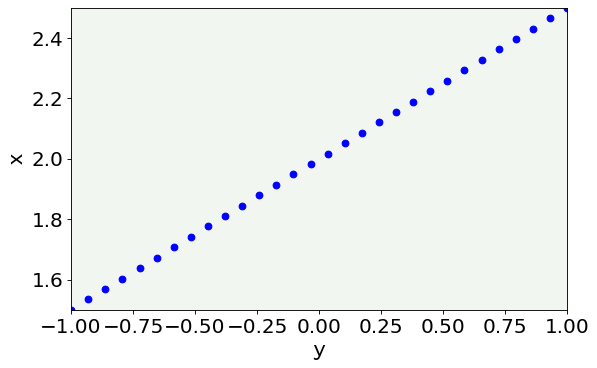

In [6]:
# plot the data we are going to use

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(x, y, marker = 'o', c = 'blue')

plt.ylabel('x', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('y', fontproperties = fm.FontProperties(fname = f))

plt.ylim(min(y), max(y))
plt.xlim(min(x), max(x))

plt.axis(True)
plt.show()

In [7]:
# Equation (4)
def hypothesis(x,w0,w1):
  return w0 + w1*x

To do linear regression we will minimize the Mean Squared Error (MSE).For that we need to define it as a Python function.

In [8]:
# Equation (3)
def cost_function_mse(x,y,w0,w1):
  return np.mean((y - hypothesis(x,w0,w1))**2)/2

## Gradient Descent Implementation

Since in Keras (with TensorFlow > 2.X) you don't have the gradient descent optimizer out of the box here is an implementation from scratch to compare it to the other optimizers.

In [9]:
def gradient_descent(x,y,x0,y0,gamma,epochs):
  """
  Returns w0 and w1 that minimizes J(w) [the cost function] and the cost 
  function at each epoch. 
  Inputs:
  - x: samples (array)
  - y: output (array)
  - gamma: learning rate
  - epochs: number of epochs to be performed
  """
  random.seed(42)
  w0_list = [x0]
  w1_list = [y0]
  w0 = x0 # randomly initialize w0
  w1 = y0 # randomly initialize w1
  m = len(x) # number of samples
  cf = []
  for i in range(epochs): # repeat n times (n: number of epochs)
    w0 = w0*(1 - gamma) + (gamma/m)*np.sum(y - w1*x) # update w0
    w1 = w1 + (gamma/m)*np.sum((y - w0 - w1*x)*x) # update w1
    cf.append(cost_function_mse(x,y,w0,w1))
    w0_list.append(w0)
    w1_list.append(w1)

  return w0_list,w1_list,cf

We initialize the two parameters (or weights) to the values of $0,0$, contained in the variables `w0_start` and `w1_start`.

In [10]:
epochs = 200
w0_start = 0.0
w1_start = 0.0
w0l,w1l,cfl = gradient_descent(x,y,w0_start,w1_start,0.1,epochs)

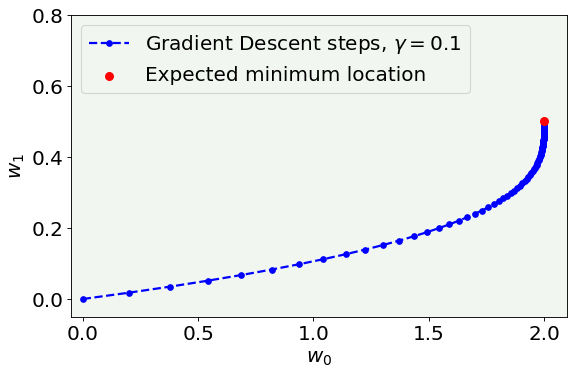

In [11]:
# Cost function vs Iterations plot

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(w0l, w1l, 'k--', color = 'blue', label = 'Gradient Descent steps, $\gamma = 0.1$', marker = 'o', markersize = 5)

plt.ylabel('$w_1$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('$w_0$', fontproperties = fm.FontProperties(fname = f))

plt.scatter([w0],[w1], zorder = 100, color = 'red', s = 50, label = 'Expected minimum location')

plt.ylim(-0.05, 0.8)
plt.xlim(-0.05, None)

plt.axis(True)
legend = ax.legend(loc = 'upper left')

fig.savefig('Figure_GD_alone.png', dpi = 300)
plt.show()

## Optimization with Adam and RMSProp (from TensorFlow implementation)

In the following sections we will minimize the loss function with the different optimizers. To do this we will do linear regression by using a neural network with one neuron without any activation function and by using a custom training loop to keep track of what each optimizer is doing.

In [13]:
# one unit as network's output
# identity function as activation function
# sequential groups a linear stack of layers into a tf.keras.Model
# activation parameter: if you don't specify anything, no activation 
# is applied (i.e. "linear" activation: a(x) = x).
model = keras.Sequential([ 
  layers.Dense(1, input_shape = [1], use_bias = True)
])

# optimizer that implements the Adam algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

# Mean Square Error (mse)
loss_fn = keras.losses.MeanSquaredError()

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
x_ = np.array(x).reshape(len(x),1)
y_ = np.array(y).reshape(len(y),1)

To make the results comparable we initilize the weights to the same values that we have used for the gradient descent implementation.

In [16]:
model.set_weights([np.array([w0_start]).reshape(1,1),np.array([w1_start]).reshape(1,)])
print(model.layers[0].get_weights())

[array([[0.]], dtype=float32), array([0.], dtype=float32)]


# Adam Optimizer Loop

In [17]:
w0_adam_list = [w0_start]
w1_adam_list = [w1_start]

# optimizer that implements the RMSprop algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)


for epoch in range(200):
    
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        ypred = model(x_, training=True)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_, ypred)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Save the weights to be able to plot them later
    w1_adam_list.append(float(model.get_weights()[0][0]))
    w0_adam_list.append(float(model.get_weights()[1][0]))
    
    # Some old school debugging (i.e. printing messages ;-))
    if (epoch % 20 == 0):
      print("epoch", epoch, " / ", model.get_weights())


epoch 0  /  [array([[0.09999911]], dtype=float32), array([0.09999992], dtype=float32)]
epoch 20  /  [array([[0.42432478]], dtype=float32), array([1.8398129], dtype=float32)]
epoch 40  /  [array([[0.5244303]], dtype=float32), array([2.2219062], dtype=float32)]
epoch 60  /  [array([[0.51567084]], dtype=float32), array([1.9516284], dtype=float32)]
epoch 80  /  [array([[0.50590926]], dtype=float32), array([1.9958987], dtype=float32)]
epoch 100  /  [array([[0.50202054]], dtype=float32), array([2.0070696], dtype=float32)]
epoch 120  /  [array([[0.50047296]], dtype=float32), array([1.9965487], dtype=float32)]
epoch 140  /  [array([[0.49994057]], dtype=float32), array([2.0013118], dtype=float32)]
epoch 160  /  [array([[0.49990508]], dtype=float32), array([1.99954], dtype=float32)]
epoch 180  /  [array([[0.49998975]], dtype=float32), array([2.00016], dtype=float32)]


# RMSProp Loop

In [18]:
w0_rmsprop_list = [w0_start]
w1_rmsprop_list = [w1_start]


model.set_weights([np.array([w0_start]).reshape(1,1),np.array([w1_start]).reshape(1,)])
print(model.layers[0].get_weights())

# optimizer that implements the RMSprop algorithm
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.02)


for epoch in range(200):
    
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        ypred = model(x_, training=True)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_, ypred)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    w1_rmsprop_list.append(float(model.get_weights()[0][0]))
    w0_rmsprop_list.append(float(model.get_weights()[1][0]))
    
    if (epoch % 20 == 0):
      print("epoch", epoch, " / ", model.get_weights())


[array([[0.]], dtype=float32), array([0.], dtype=float32)]
epoch 0  /  [array([[0.06324548]], dtype=float32), array([0.06324554], dtype=float32)]
epoch 20  /  [array([[0.43024722]], dtype=float32), array([0.5629626], dtype=float32)]
epoch 40  /  [array([[0.49914235]], dtype=float32), array([0.926377], dtype=float32)]
epoch 60  /  [array([[0.5]], dtype=float32), array([1.2652179], dtype=float32)]
epoch 80  /  [array([[0.5000007]], dtype=float32), array([1.5768003], dtype=float32)]
epoch 100  /  [array([[0.5016935]], dtype=float32), array([1.8357472], dtype=float32)]
epoch 120  /  [array([[0.50949186]], dtype=float32), array([1.9809263], dtype=float32)]
epoch 140  /  [array([[0.51007926]], dtype=float32), array([1.999977], dtype=float32)]
epoch 160  /  [array([[0.5097873]], dtype=float32), array([2.], dtype=float32)]
epoch 180  /  [array([[0.51010305]], dtype=float32), array([2.], dtype=float32)]


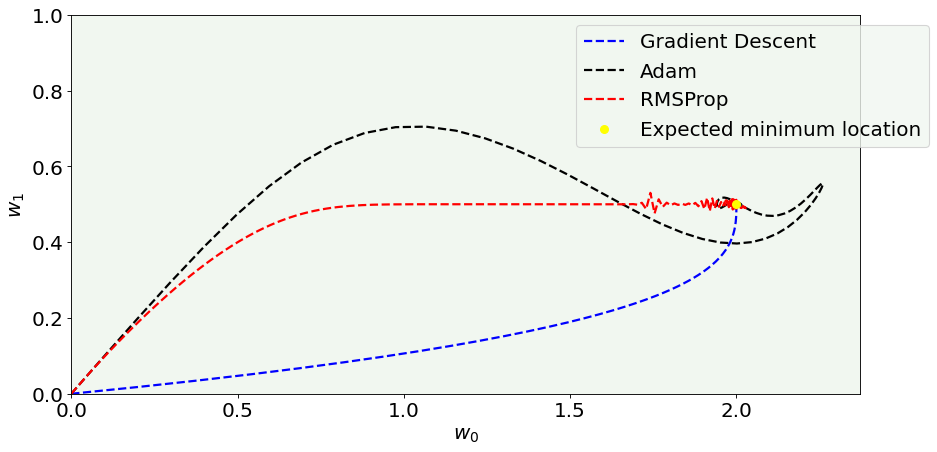

In [19]:
# Cost function vs Iterations plot

fig = plt.figure(figsize = (12,6))
#ax = fig.add_subplot(111)

plt.plot(w0l, w1l, 'k--', color = 'blue', label = 'Gradient Descent')#, marker = 'o', markersize = 5)
plt.plot(w0_adam_list, w1_adam_list, 'k--', color = 'black', label = 'Adam')#, marker = 'o', markersize = 5)
plt.plot(w0_rmsprop_list, w1_rmsprop_list, 'k--', color = 'red', label = 'RMSProp')#, marker = 'o', markersize = 5)


plt.ylabel('$w_1$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('$w_0$', fontproperties = fm.FontProperties(fname = f))
plt.scatter([w0],[w1], color = 'yellow', s = 50, zorder = 500, label = 'Expected minimum location')
#plt.xticks([0,5,10,15,20])

plt.ylim(0, 1.0)
plt.xlim(0, None)

plt.axis(True)
plt.legend(loc = 'best', bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
fig.savefig('Figure_optimizers.png', dpi = 300)

plt.show()

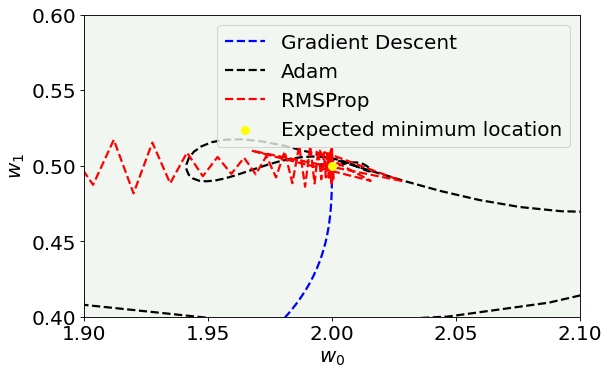

In [20]:
# Cost function vs Iterations plot

fig = plt.figure()
ax = fig.add_subplot(111)
start_epoch = 0

plt.plot(w0l[start_epoch:200], w1l[start_epoch:200], 'k--', color = 'blue', label = 'Gradient Descent')#, marker = 'o', markersize = 5)
plt.plot(w0_adam_list[start_epoch:200], w1_adam_list[start_epoch:200], 'k--', color = 'black', label = 'Adam')#, marker = 'o', markersize = 5)
plt.plot(w0_rmsprop_list[start_epoch:200], w1_rmsprop_list[start_epoch:200], 'k--', color = 'red', label = 'RMSProp')#, marker = 'o', markersize = 5)


plt.ylabel('$w_1$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('$w_0$', fontproperties = fm.FontProperties(fname = f))

plt.scatter([w0],[w1], color = 'yellow', s = 50, zorder = 500, label = 'Expected minimum location')
#plt.xticks([0,5,10,15,20])

plt.ylim(0.4, 0.6)
plt.xlim(1.9, 2.1)

plt.axis(True)
legend = ax.legend(loc = 'best')

plt.show()

# Plots vs. the EPOCH number

Here you can see what is the value of the parameters vs. the number of epochs to get an idea of how the parameters converges to the expected value.

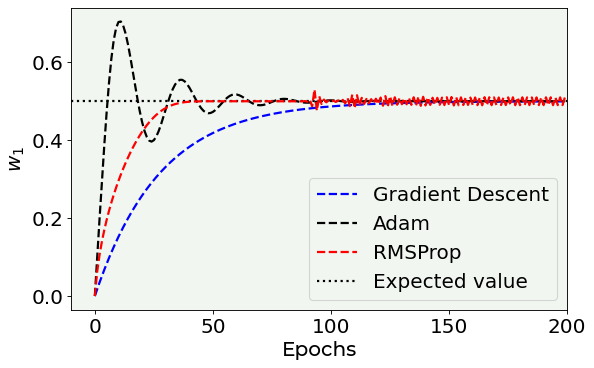

In [22]:
# Cost function vs Iterations plot

fig = plt.figure()
start_epoch = 0

plt.plot(np.arange(0,200), w1l[start_epoch:200], 'k--', color = 'blue', label = 'Gradient Descent')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w1_adam_list[start_epoch:200], 'k--', color = 'black', label = 'Adam')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w1_rmsprop_list[start_epoch:200], 'k--', color = 'red', label = 'RMSProp')#, marker = 'o', markersize = 5)


plt.ylabel('$w_1$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('Epochs', fontproperties = fm.FontProperties(fname = f))
plt.hlines(0.5, -10, 200, ls = 'dotted', label = 'Expected value')

plt.xlim(-10,200)
plt.axis(True)
plt.legend(loc = 'best')
fig.savefig('w1_vs_n.png', dpi = 300)

plt.show()

Note that the RMSProp optimizer oscillates around the correct value and you can see that clearly if you zoom around the expected value (see below).

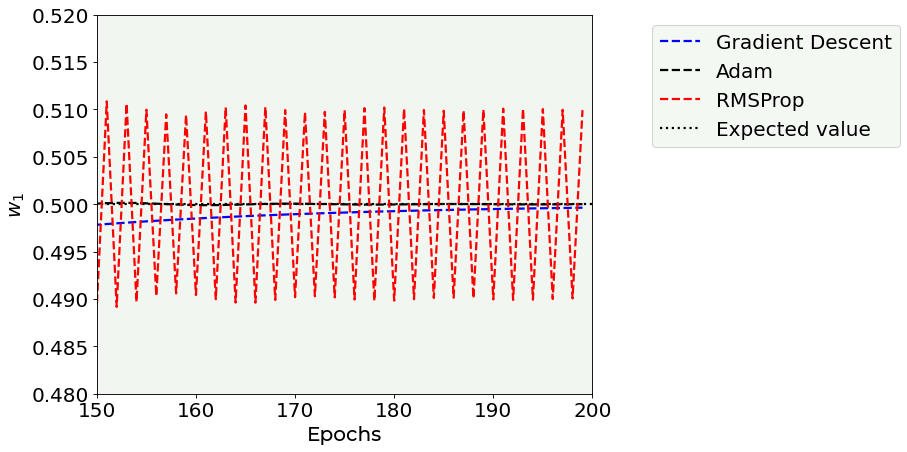

In [23]:

# Cost function vs Iterations plot

fig = plt.figure(figsize = (12,6))
start_epoch = 0

plt.plot(np.arange(0,200), w1l[start_epoch:200], 'k--', color = 'blue', label = 'Gradient Descent')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w1_adam_list[start_epoch:200], 'k--', color = 'black', label = 'Adam')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w1_rmsprop_list[start_epoch:200], 'k--', color = 'red', label = 'RMSProp')#, marker = 'o', markersize = 5)


plt.ylabel('$w_1$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('Epochs', fontproperties = fm.FontProperties(fname = f))
plt.hlines(0.5, -10, 200, ls = 'dotted', label = 'Expected value')

plt.xlim(150,200)
plt.ylim(0.48, 0.52)
plt.axis(True)
plt.legend(loc = 'best', bbox_to_anchor=(1.1, 1.0))
plt.tight_layout()
fig.savefig('w1_vs_n_zoom.png', dpi = 300)

plt.show()

The next plot is a zoom on the first epochs to give you an idea about how fast the parameter values get close to the expected values.

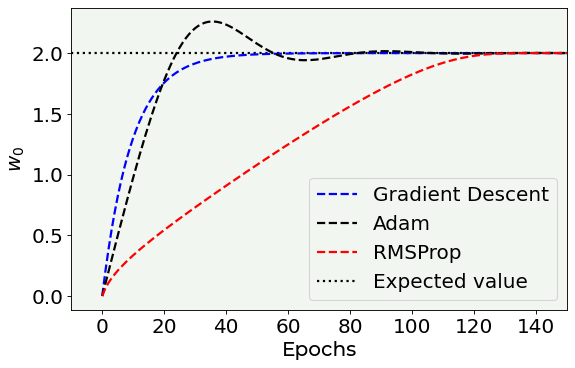

In [25]:
# Cost function vs Iterations plot

fig = plt.figure()
start_epoch = 0

plt.plot(np.arange(0,200), w0l[start_epoch:200], 'k--', color = 'blue', label = 'Gradient Descent')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w0_adam_list[start_epoch:200], 'k--', color = 'black', label = 'Adam')#, marker = 'o', markersize = 5)
plt.plot(np.arange(0,200), w0_rmsprop_list[start_epoch:200], 'k--', color = 'red', label = 'RMSProp')#, marker = 'o', markersize = 5)
plt.hlines(2.0, -10, 200, ls = 'dotted', label = 'Expected value')


plt.ylabel('$w_0$', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('Epochs', fontproperties = fm.FontProperties(fname = f))
#plt.scatter([w0],[w1], color = 'red', s = 30)
#plt.xticks([0,5,10,15,20])

#plt.ylim(0.45, 0.55)
plt.xlim(-10,150)

plt.axis(True)
plt.legend(loc = 'best')
fig.savefig('w0_vs_n.png', dpi = 300)

plt.show()

# 3D MSE Surface

You can use the code in this cell to plot the trajectory in parameter space in 3D overlapped on the loss function 3D plot.

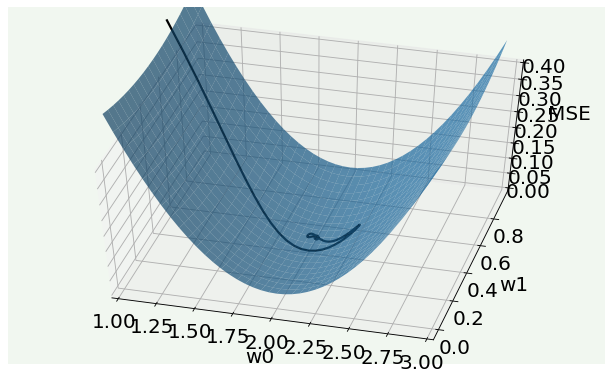

In [26]:

from mpl_toolkits.mplot3d import Axes3D


def fun(w0, w1):
    return np.mean((y - hypothesis(x,w0,w1))**2)/2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
w0_ = w1_ = np.arange(1.0, 3.0, 0.05)
w1_ = np.arange(0.0, 1.0, 0.05)
w0__, w1__ = np.meshgrid(w0_, w1_)
zs = np.array([fun(xx,yy) for xx,yy in zip(np.ravel(w0__), np.ravel(w1__))])
Z = zs.reshape(w0__.shape)

ax.scatter3D(2.0, 0.5, color = 'black')
adamx = w0_adam_list[10:200]
adamy = w1_adam_list[10:200]
z = np.array([fun(xx,yy) for xx,yy in zip(np.ravel(adamx), np.ravel(adamy))])
ax.plot3D(adamx, adamy, z, color = 'black')

ax.view_init(50, -75)
ax.plot_surface(w0__, w1__, Z, alpha = 0.7)

ax.set_xlim(1.0,3.0)
ax.set_zlim(0.0,0.4)
ax.set_xlabel('w0', labelpad=10)
ax.set_ylabel('w1', labelpad=10)
ax.set_zlabel('MSE', labelpad=10)


plt.tight_layout()
plt.show()